# Generating Surface Densities from the nonlinear shocking formula

The code offers one main function for generating surface density from a set of input parameters `construct_surface_density`. This is called with a linear array of radial points (the planet is always placed at R = 1), a surface density slope, the local height of the disk at the planet (h_p), the mass of the planet in thermal masses ($m_p$) and the number of orbits since the planet was added into the disk.

See CR21 (*Planet-driven density waves in protoplanetary discs: Numerical verification of non-linear evolution theory*), and the first line of figure A1 in paper 2 (*Emergence of vortices at the edges of planet-driven gaps in protoplanetary discs*).

Text(0.5, 1.0, 'Constructed surface densities for a $m_p/m_{th} = 0.25$ planet')

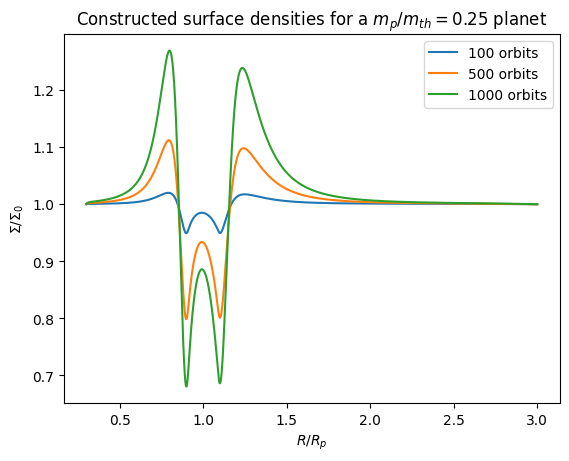

In [1]:
from matplotlib import pyplot as plt
from vortensity_k.generate_density_profile import construct_surface_density
import numpy as np

orbits = [100, 500, 1000]

m_p = 0.25
p = 1.5
h_p = 0.05


R = np.linspace(0.3, 3, 2000)

for i in range(len(orbits)):
    sigma, error = construct_surface_density(R, p, h_p, m_p, orbits[i])
    plt.plot(R, sigma * R**(p), label='{} orbits'.format(orbits[i]))
    
plt.legend()
plt.xlabel('$R/R_p$')
plt.ylabel('$\Sigma/\Sigma_0$')
plt.title('Constructed surface densities for a $m_p/m_{th} = 0.25$ planet')

# The $2 \pi$ discrepency and passing custom vortensity
This work contains an extra factor of $2 \pi$ to my calculation of the change in vortensity over time. This was 
discovered while writing this code and is due to a mistake in normalisation in the original paper.

Below is an example of computing the vortensity manually, as well as a comparison the examples show in figure A1
in the paper CR23.

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import os

# import generate_density_profile
from vortensity_k.constants import k_b, G
from vortensity_k.generate_density_profile import (
    compute_delta_zeta, reconstruct_surface_density,
    background_vortensity)

directory = "reference_data/"

files = os.listdir(directory)
models = []

for f in files:
    items = f.split("-")
    models.append(
        {'filename': f,
         'm_p': float(items[1][:-1]),
         'h_p': float(items[2][1:])/100 if float(items[2][1:]) != 1 else 0.1,
         'p': float(items[3].split("_")[0][1:]),
         'time': float(items[3].split("_")[1][1:])
        }
    )

{'filename': 'ISO-0.5M-h05-q1.5_t60_rec_disc.npy', 'm_p': 0.5, 'h_p': 0.05, 'p': 1.5, 'time': 60.0}
p,  1.5
{'filename': 'ISO-0.25M-h1-q1.5_t300_rec_disc.npy', 'm_p': 0.25, 'h_p': 0.1, 'p': 1.5, 'time': 300.0}
p,  1.5
{'filename': 'ISO-0.1M-h05-q1.5_t6800_rec_disc.npy', 'm_p': 0.1, 'h_p': 0.05, 'p': 1.5, 'time': 6800.0}
p,  1.5
{'filename': 'ISO-0.25M-h05-q0_t650_rec_disc.npy', 'm_p': 0.25, 'h_p': 0.05, 'p': 0.0, 'time': 650.0}
p,  0.0


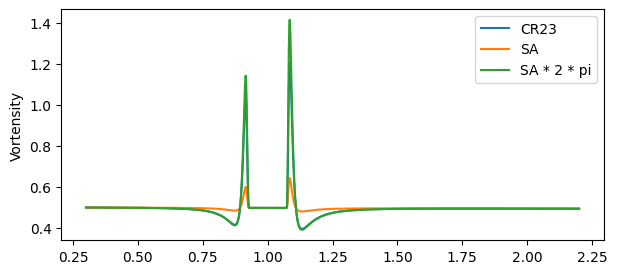

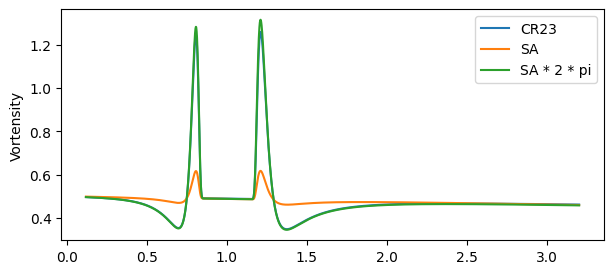

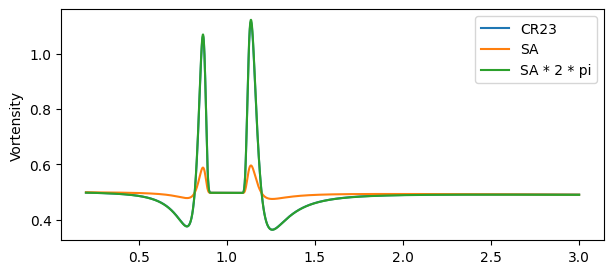

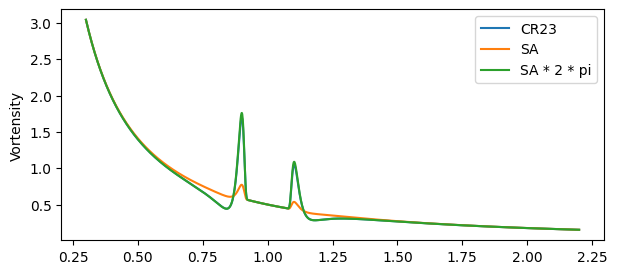

In [3]:
for m in models:
    print(m)
    
    h_p = m['h_p']
    m_p = m['m_p']
    p = m['p']
    
    print("p, ", p)

    R, vortensity, dsigma, domega = np.load(
        directory + m['filename'], allow_pickle=True)

    sigma_0 = R[1:-1]**(-1 * m['p'])
    omega_k = R[1:-1]**(-3/2)

    sigma = sigma_0 * (1 + dsigma[1:-1])
    omega = domega[1:-1] * omega_k
    
    # Attempt calculations 
    del_zeta = compute_delta_zeta(R[1:-1], p, h_p, m_p)
        
    del_zeta_del_t = del_zeta * np.abs(R[1:-1]**(-3/2) - 1)/(2 * np.pi)
    actual_time = m['time'] * 2 * np.pi
    
    # We have to multiply del_zeta by 2pi (not contained in the equations in the paper)
    
    zeta = (background_vortensity(R[1:-1], p, h_p) +
         (del_zeta_del_t * actual_time))
            
    zeta_adjusted = (background_vortensity(R[1:-1], p, h_p) +
         (del_zeta_del_t * actual_time * 2 * np.pi))
    
    zeta_adjusted_2 = (0.5 +
     (del_zeta_del_t * actual_time * 2 * np.pi))

    plt.figure(figsize=(7, 3))
    plt.plot(R[1:-1], vortensity, label="CR23")
    plt.plot(R[1:-1], zeta, label="SA")
    plt.plot(R[1:-1], zeta_adjusted, label="SA * 2 * pi")

    plt.ylabel("Vortensity")
    plt.legend()


It is clear that the factor of $2 \pi$ is nessecary, and reproduces the work in the paper correctly.

{'filename': 'ISO-0.5M-h05-q1.5_t60_rec_disc.npy', 'm_p': 0.5, 'h_p': 0.05, 'p': 1.5, 'time': 60.0}
p,  1.5
{'filename': 'ISO-0.25M-h1-q1.5_t300_rec_disc.npy', 'm_p': 0.25, 'h_p': 0.1, 'p': 1.5, 'time': 300.0}
p,  1.5
{'filename': 'ISO-0.1M-h05-q1.5_t6800_rec_disc.npy', 'm_p': 0.1, 'h_p': 0.05, 'p': 1.5, 'time': 6800.0}
p,  1.5
{'filename': 'ISO-0.25M-h05-q0_t650_rec_disc.npy', 'm_p': 0.25, 'h_p': 0.05, 'p': 0.0, 'time': 650.0}
p,  0.0


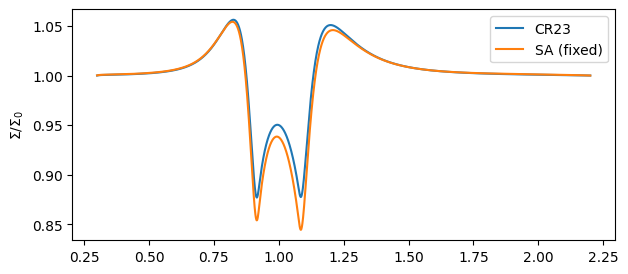

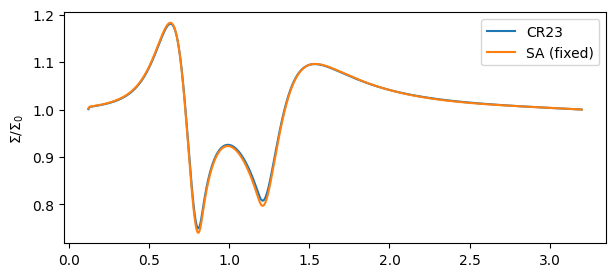

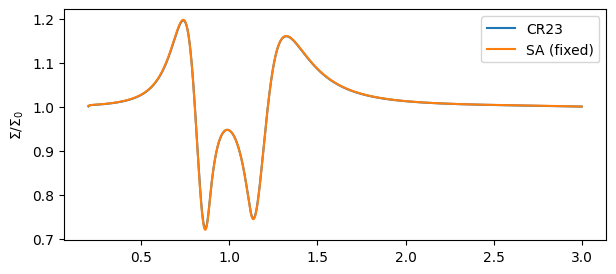

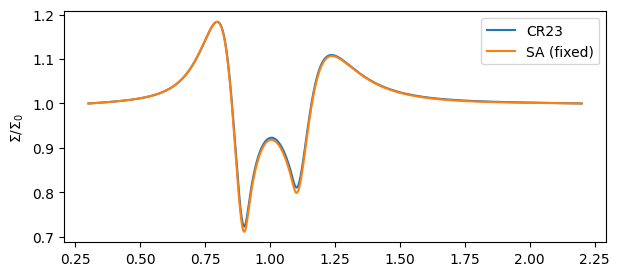

In [7]:
for m in models:
    print(m)
    
    h_p = m['h_p']
    m_p = m['m_p']
    p = m['p']
    
    print("p, ", p)

    R, vortensity, dsigma, domega = np.load(
        directory + m['filename'], allow_pickle=True)

    sigma_0 = R[1:-1]**(-1 * m['p'])
    omega_k = R[1:-1]**(-3/2)

    sigma = sigma_0 * (1 + dsigma[1:-1])
    omega = domega[1:-1] * omega_k
    
    # Attempt calculations 
    del_zeta = compute_delta_zeta(R[1:-1], p, h_p, m_p)
        
    del_zeta_del_t = del_zeta * np.abs(R[1:-1]**(-3/2) - 1)/(2 * np.pi)
    actual_time = m['time'] * 2 * np.pi
    
    # We have to multiply del_zeta by 2pi (not contained in the equations in the paper)
    
    zeta_adjusted = (background_vortensity(R[1:-1], p, h_p) +
         (del_zeta_del_t * actual_time * 2 * np.pi))
    
    sigma_re, error = construct_surface_density(R, p, h_p, m_p, m['time']) # reconstruct_surface_density(R[1:-1], p, h_p, zeta_adjusted)

    plt.figure(figsize=(7, 3))
    plt.plot(R[1:-1], sigma/sigma_0, label="CR23")
    plt.plot(R[1:-1], sigma_re[1:-1]/sigma_0, label="SA (fixed)")

    plt.ylabel("$\Sigma/\Sigma_0$")
    plt.legend()


Aside from some very slight numerical changes due to different error tolerances these match.

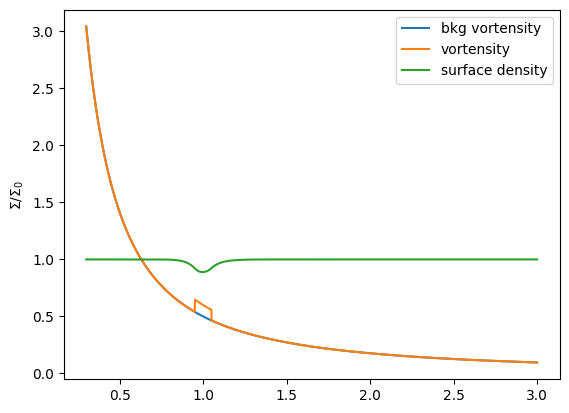

In [15]:

R = np.linspace(0.3, 3, 2000)

p = 0
sigma_0 = R**(-p)

h_p = 0.05

zeta =  background_vortensity(R, p, h_p)
zeta[np.logical_and(R > 0.95, R < 1.05)] = zeta[np.logical_and(R > 0.95, R < 1.05)] * 1.2
plt.plot(R, background_vortensity(R, p, h_p), label='bkg vortensity')

plt.plot(R, zeta, label='vortensity')

sigma, error = reconstruct_surface_density(R, p, h_p, zeta,
                                c=2/3, max_relative_error=1e-7,
                                max_iter=500000, guess=None)


plt.plot(R, sigma, label="surface density")

plt.ylabel("$\Sigma/\Sigma_0$")
plt.legend()
